# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [17]:
# drive.mount('/content/drive')

# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

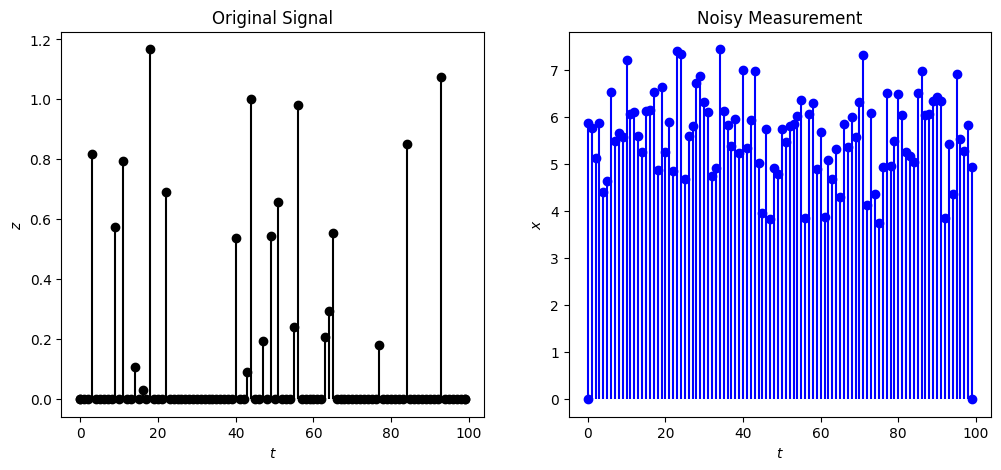

In [2]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [3]:

import numpy as np
import matplotlib.pyplot as plt

class ISTA:
    def __init__(self, lambd: float, max_iter=1000, tol=1e-6):
        self.lambd = lambd
        self.max_iter = max_iter
        self.tol = tol
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding with a non-negativity constraint."""
        return np.maximum(0, np.sign(z) * np.maximum(0, np.abs(z) - T))  # Ensure non-negative values

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        grad_step = z + (1 / alpha) * A.T @ (x - A @ z)
        z_new = self._soft(grad_step, self.lambd / (2 * alpha))
        reconstruction_loss = np.linalg.norm(x - A @ z_new, 2) ** 2
        sparsity_loss = self.lambd * np.linalg.norm(z_new, 1)
        combined_loss = reconstruction_loss + sparsity_loss
        return z_new, reconstruction_loss, sparsity_loss, combined_loss

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        z = np.zeros(A.shape[1])
        for i in range(self.max_iter):
            z_new, reconstruction_loss, sparsity_loss, combined_loss = self._run_one_iter(z, x, A, alpha)
            self.loss_history_reconstruction.append(reconstruction_loss)
            self.loss_history_sparse.append(sparsity_loss)
            self.loss_history_combined.append(combined_loss)
            
            if np.linalg.norm(z_new - z, 2) < self.tol:
                print(f"Converged at iteration {i}")
                break
            z = z_new
        return z

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history_reconstruction, label='Reconstruction Loss')
        plt.plot(self.loss_history_sparse, label='Sparsity Loss')
        plt.plot(self.loss_history_combined, label='Combined Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()
        plt.show()

    def visualize_signals(self, original_z, recovered_z):
        """Visualize the original and recovered signals."""
        t = np.arange(len(original_z))
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].stem(t, original_z, "k", basefmt="ko")
        ax[0].set_title("Original Signal")
        ax[0].set_xlabel(r'$t$')
        ax[0].set_ylabel(r'$z$')

        ax[1].stem(t, recovered_z, "b", basefmt="bo")
        ax[1].set_title("Recovered Signal")
        ax[1].set_xlabel(r'$t$')
        ax[1].set_ylabel(r'$z$')

        plt.show()




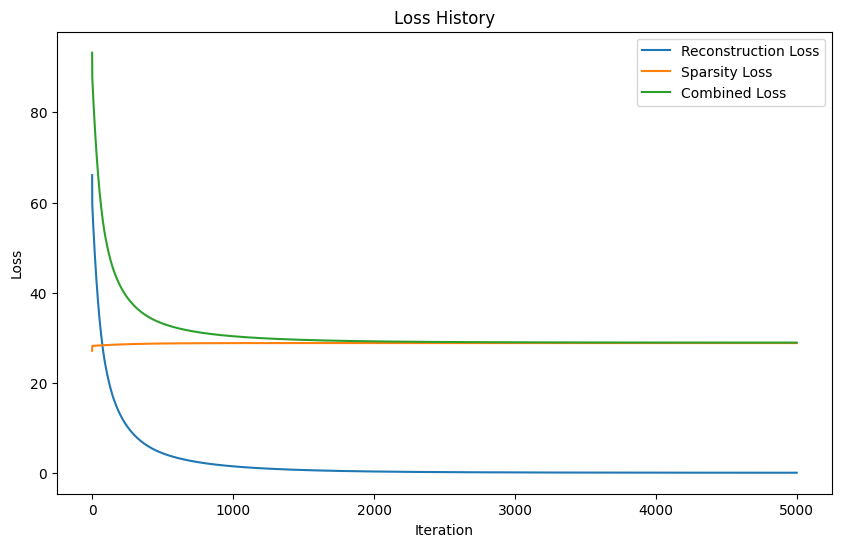

In [5]:
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100
z_recovered = opt.optimize(A, x, alpha)
opt.visualize_loss_history()

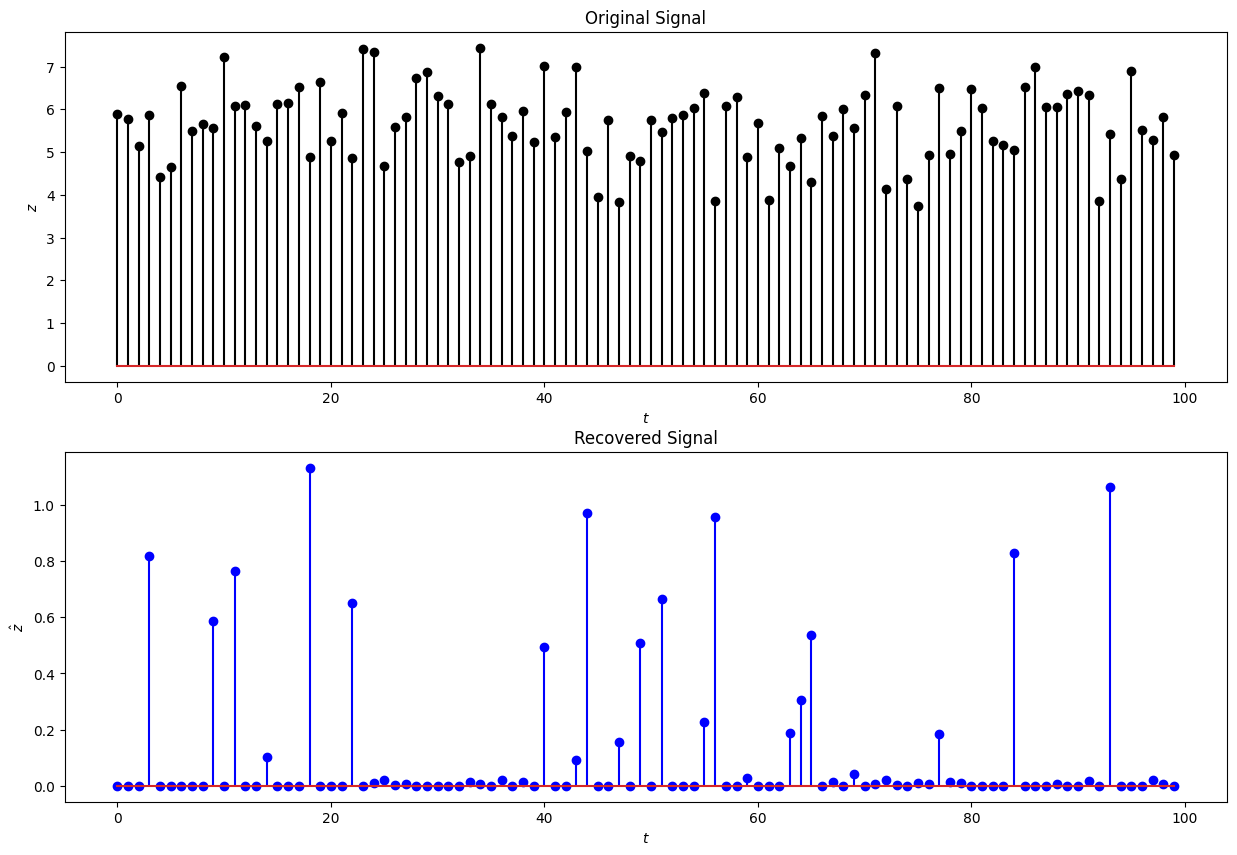

In [6]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

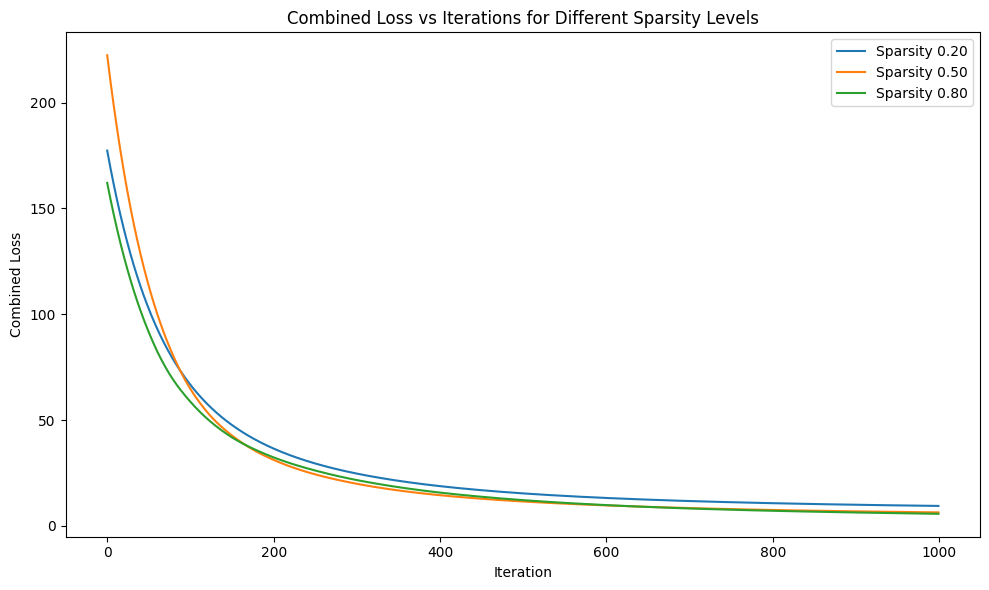

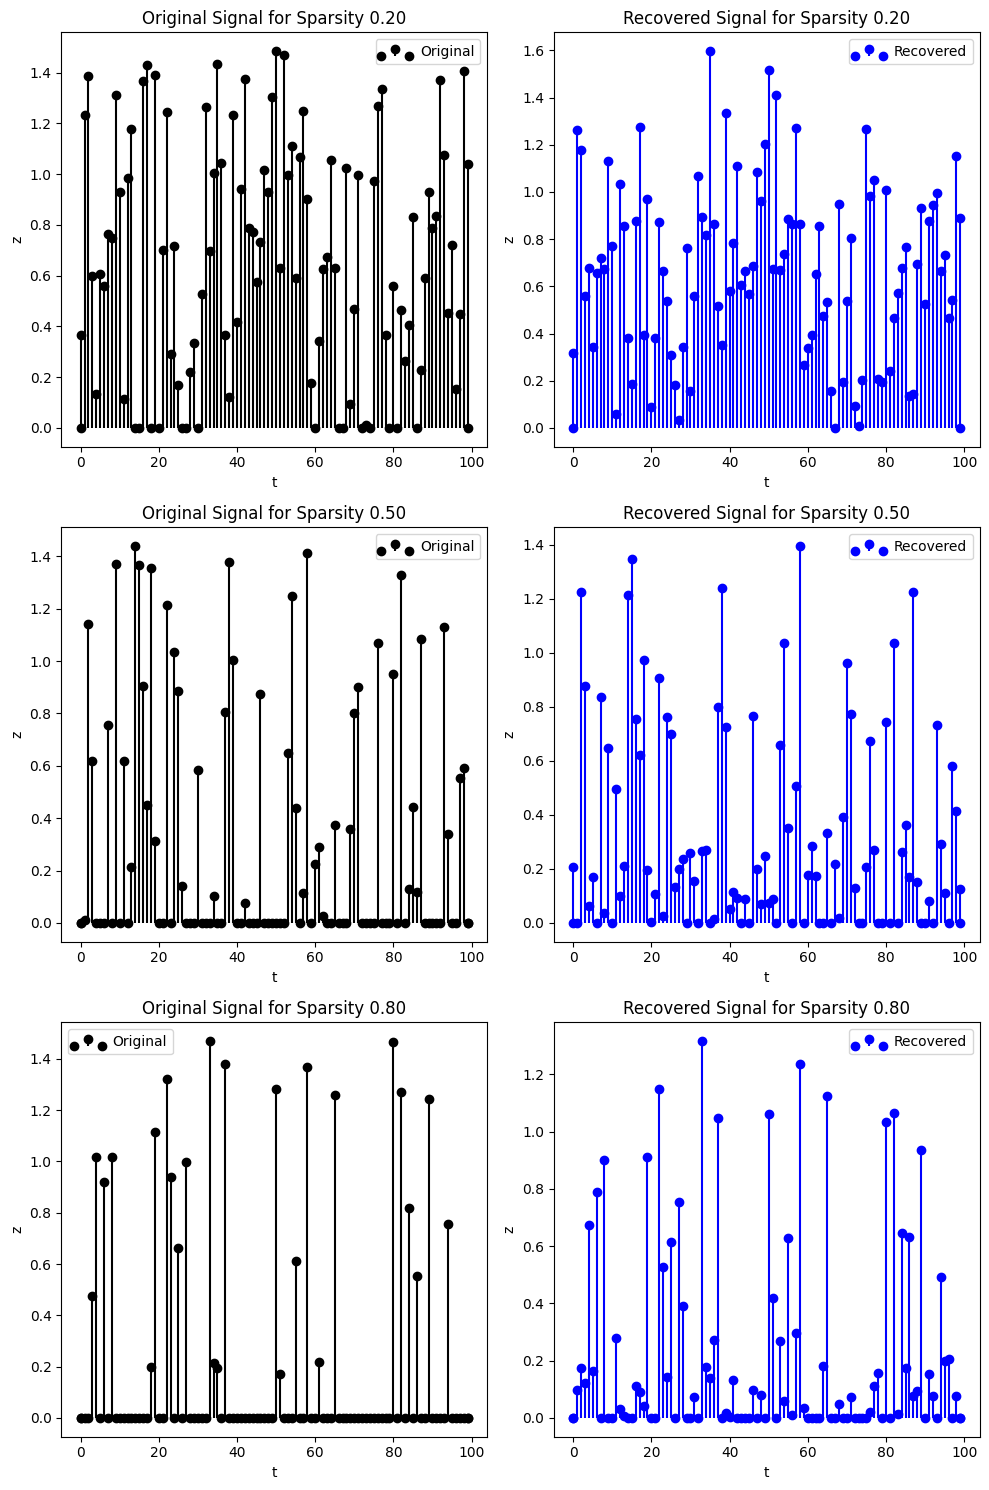

In [7]:

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


def generate_sparse_signal(length, sparsity_level):
    """
    Generate a sparse signal with a given sparsity level.
    sparsity_level is the fraction of zero elements (e.g., 0.8 means 80% zeros).
    """
    z = 1.5 * np.random.rand(length)
    z = z * np.array([0 if np.random.rand() < sparsity_level else 1 for _ in range(length)])
    return z


def run_experiments(sparsity_levels, signal_length, A, noise_sigma, lambd, max_iter=1000):
    """
    Run ISTA for signals with different sparsity levels and compare results.
    """
    alpha = np.max(np.linalg.eigvals(A.T @ A)) 
    results = {}

    for sparsity_level in sparsity_levels:
        z = generate_sparse_signal(signal_length, sparsity_level)
        noise = np.random.normal(0, noise_sigma, size=signal_length)
        x = A @ z + noise

        ista = ISTA(lambd=lambd, max_iter=max_iter)
        recovered_z = ista.optimize(A, x, alpha)

        results[sparsity_level] = {
            'original_z': z,
            'recovered_z': recovered_z,
            'loss_history_reconstruction': ista.loss_history_reconstruction,
            'loss_history_combined': ista.loss_history_combined
        }
    
    return results


def visualize_experiment_results(results):
    """
    Visualize the results for different sparsity levels.
    """
    num_sparsity_levels = len(results)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    for sparsity_level, result in results.items():
        ax.plot(result['loss_history_combined'], label=f'Sparsity {sparsity_level:.2f}')

    ax.set_title('Combined Loss vs Iterations for Different Sparsity Levels')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Combined Loss')
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(num_sparsity_levels, 2, figsize=(10, 5 * num_sparsity_levels))

    for i, (sparsity_level, result) in enumerate(results.items()):
        t = np.arange(len(result['original_z']))
        
        # Plot original signal
        ax[i, 0].stem(t, result['original_z'], "k", basefmt="ko", label='Original')
        ax[i, 0].set_title(f'Original Signal for Sparsity {sparsity_level:.2f}')
        ax[i, 0].set_xlabel('t')
        ax[i, 0].set_ylabel('z')
        ax[i, 0].legend()

        # Plot recovered signal
        ax[i, 1].stem(t, result['recovered_z'], "b", basefmt="bo", label='Recovered')
        ax[i, 1].set_title(f'Recovered Signal for Sparsity {sparsity_level:.2f}')
        ax[i, 1].set_xlabel('t')
        ax[i, 1].set_ylabel('z')
        ax[i, 1].legend()

    plt.tight_layout()
    plt.show()


sparsity_levels = [0.2, 0.5, 0.8] 
signal_length = 100
A = np.random.rand(signal_length, signal_length)
noise_sigma = 0.05
lambd = 0.1
max_iter = 1000

results = run_experiments(sparsity_levels, signal_length, A, noise_sigma, lambd, max_iter)
visualize_experiment_results(results)


## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [8]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [11]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [12]:
# DO NOT MODIFY
filename = "/kaggle/input/signal-dataset/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [42]:
def visualize(model, test_loader, num_samples, configs, epoch_losses):
    model.eval()
    fig, axs = plt.subplots(3, num_samples, figsize=(12, 8))
    t = np.arange(0, 100, 1)

    # Plot training loss curves
    axs[0, 0].plot(epoch_losses, label='Training Loss', color='orange')
    axs[0, 0].set_title("Training Loss Curve")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    with torch.no_grad():
        for i, (z, x) in enumerate(test_loader):
            if i == num_samples:
                break
            z, x = z.to(configs["device"]), x.to(configs["device"])
            z_hat = model(x)[0, :].cpu().numpy()
            z = z[0, :].cpu().numpy()

            axs[1, i].stem(t, z, "k")
            axs[1, i].set_xlabel(r'$t$')
            axs[1, i].set_ylabel(r'$z$')
            axs[1, i].set_title("Original Signal")

            axs[2, i].stem(t, z_hat, "b")
            axs[2, i].set_xlabel(r'$t$')
            axs[2, i].set_ylabel(r'$\hat{z}$')
            axs[2, i].set_title("Recovered Signal")

    plt.tight_layout()
    plt.show()
    return axs


In [28]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []  
    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(configs["device"]), y.to(configs["device"])
            optimizer.zero_grad()
            x_hat = model(y)
            loss = loss_fn(x_hat, x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)  # Log loss
        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")
    return epoch_losses 


def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  num_params = sum(p.numel() for p in model.parameters())
  print(f"Number of Parameters: {num_params}")
  return avg_loss, avg_sparsity


In [29]:

class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.threshold = nn.Parameter(torch.tensor(0.1))  
    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""
        return torch.sign(x) * torch.maximum(torch.abs(x) - T, torch.zeros_like(x))

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""
        z = self.linear(x)
        return self._soft(z, self.threshold)

class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""
        super().__init__()
        self.num_layers = configs.get("num_layers", 5)
        self.input_dim = configs["input_dim"]
        self.output_dim = configs["output_dim"]
        self.hidden_dim = configs["hidden_dims"][0]
        
        self.blocks = nn.ModuleList()
        for i in range(self.num_layers):
            if i == 0:
                self.blocks.append(ISTABlock(self.input_dim, self.hidden_dim))
            elif i == self.num_layers - 1:
                self.blocks.append(ISTABlock(self.hidden_dim, self.output_dim))
            else:
                self.blocks.append(ISTABlock(self.hidden_dim, self.hidden_dim))


    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""
        for layer in self.blocks:
            x = layer(x)
        return x



In [16]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [512, 512],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 100,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [32]:
import torch.optim as optim
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
optimizer = optim.AdamW(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)


Epoch: [1/100], Loss: 0.1499
Epoch: [2/100], Loss: 0.1474
Epoch: [3/100], Loss: 0.1367
Epoch: [4/100], Loss: 0.1208
Epoch: [5/100], Loss: 0.1057
Epoch: [6/100], Loss: 0.0937
Epoch: [7/100], Loss: 0.0860
Epoch: [8/100], Loss: 0.0813
Epoch: [9/100], Loss: 0.0791
Epoch: [10/100], Loss: 0.0780
Epoch: [11/100], Loss: 0.0774
Epoch: [12/100], Loss: 0.0763
Epoch: [13/100], Loss: 0.0744
Epoch: [14/100], Loss: 0.0709
Epoch: [15/100], Loss: 0.0668
Epoch: [16/100], Loss: 0.0635
Epoch: [17/100], Loss: 0.0612
Epoch: [18/100], Loss: 0.0596
Epoch: [19/100], Loss: 0.0574
Epoch: [20/100], Loss: 0.0560
Epoch: [21/100], Loss: 0.0548
Epoch: [22/100], Loss: 0.0538
Epoch: [23/100], Loss: 0.0530
Epoch: [24/100], Loss: 0.0512
Epoch: [25/100], Loss: 0.0499
Epoch: [26/100], Loss: 0.0496
Epoch: [27/100], Loss: 0.0495
Epoch: [28/100], Loss: 0.0493
Epoch: [29/100], Loss: 0.0492
Epoch: [30/100], Loss: 0.0492
Epoch: [31/100], Loss: 0.0491
Epoch: [32/100], Loss: 0.0491
Epoch: [33/100], Loss: 0.0490
Epoch: [34/100], Lo

[0.1498917900919914,
 0.14737441962957382,
 0.1367141079902649,
 0.12080880767107009,
 0.10567193964123726,
 0.09369185581803322,
 0.0860341717004776,
 0.08134388920664787,
 0.07906707951426506,
 0.07796717894077301,
 0.07738254553079606,
 0.07626645535230636,
 0.07438367623090744,
 0.07085306033492088,
 0.06678554448485374,
 0.0634558212608099,
 0.061235949859023094,
 0.05956421715021133,
 0.05737157337367535,
 0.05601556523144245,
 0.05482857652008533,
 0.05377535665035248,
 0.053036339864134786,
 0.05115498231351376,
 0.049851337656378746,
 0.04959537434577942,
 0.04946755862236023,
 0.04933187134563923,
 0.049192643955349925,
 0.04918579249083996,
 0.04914284548163414,
 0.049054023578763005,
 0.049008233934640884,
 0.0489935664832592,
 0.04892225082218647,
 0.04882152110338211,
 0.048838845819234845,
 0.04881914348900318,
 0.048788149908185,
 0.048693928077816966,
 0.04861308333277702,
 0.0479432310461998,
 0.047445737645030024,
 0.04708180396258831,
 0.04619688835740089,
 0.046069

Epoch: [1/100], Loss: 0.0442
Epoch: [2/100], Loss: 0.0441
Epoch: [3/100], Loss: 0.0441
Epoch: [4/100], Loss: 0.0441
Epoch: [5/100], Loss: 0.0441
Epoch: [6/100], Loss: 0.0440
Epoch: [7/100], Loss: 0.0440
Epoch: [8/100], Loss: 0.0439
Epoch: [9/100], Loss: 0.0438
Epoch: [10/100], Loss: 0.0439
Epoch: [11/100], Loss: 0.0438
Epoch: [12/100], Loss: 0.0437
Epoch: [13/100], Loss: 0.0437
Epoch: [14/100], Loss: 0.0437
Epoch: [15/100], Loss: 0.0436
Epoch: [16/100], Loss: 0.0436
Epoch: [17/100], Loss: 0.0436
Epoch: [18/100], Loss: 0.0434
Epoch: [19/100], Loss: 0.0435
Epoch: [20/100], Loss: 0.0434
Epoch: [21/100], Loss: 0.0433
Epoch: [22/100], Loss: 0.0433
Epoch: [23/100], Loss: 0.0432
Epoch: [24/100], Loss: 0.0432
Epoch: [25/100], Loss: 0.0431
Epoch: [26/100], Loss: 0.0431
Epoch: [27/100], Loss: 0.0431
Epoch: [28/100], Loss: 0.0431
Epoch: [29/100], Loss: 0.0430
Epoch: [30/100], Loss: 0.0429
Epoch: [31/100], Loss: 0.0429
Epoch: [32/100], Loss: 0.0429
Epoch: [33/100], Loss: 0.0428
Epoch: [34/100], Lo

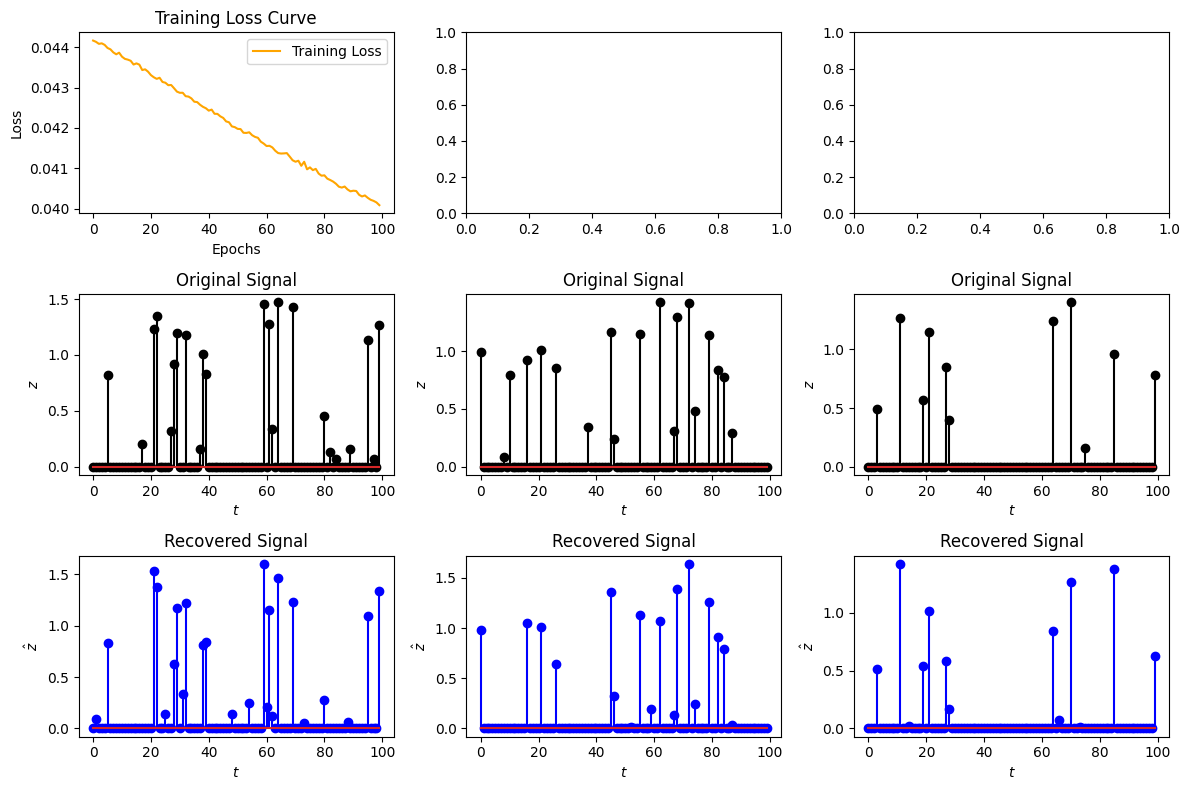

In [36]:
# avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
# _ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

epoch_losses = train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
_ = visualize(model_unfolded, test_loader, num_samples=3, configs=configs_unfolded, epoch_losses=epoch_losses)


### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

Converged at iteration 317
Converged at iteration 271
Converged at iteration 561
Converged at iteration 467
Converged at iteration 275
Converged at iteration 268
Converged at iteration 264
Converged at iteration 373
Converged at iteration 491
Converged at iteration 293
Converged at iteration 391
Converged at iteration 411
Converged at iteration 319
Converged at iteration 351
Converged at iteration 247
Converged at iteration 386
Converged at iteration 322
Converged at iteration 373
Converged at iteration 346
Converged at iteration 324
Converged at iteration 333
Converged at iteration 434
Converged at iteration 288
Converged at iteration 321
Converged at iteration 364
Converged at iteration 420
Converged at iteration 454
Converged at iteration 390
Converged at iteration 578
Converged at iteration 377
Converged at iteration 410
Converged at iteration 318
Converged at iteration 358
Converged at iteration 351
Converged at iteration 504
Converged at iteration 305
Converged at iteration 294
C

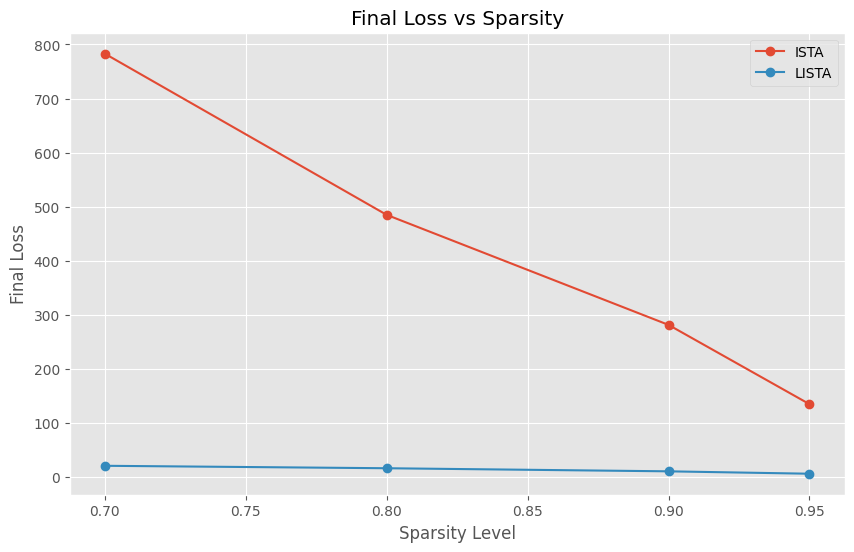

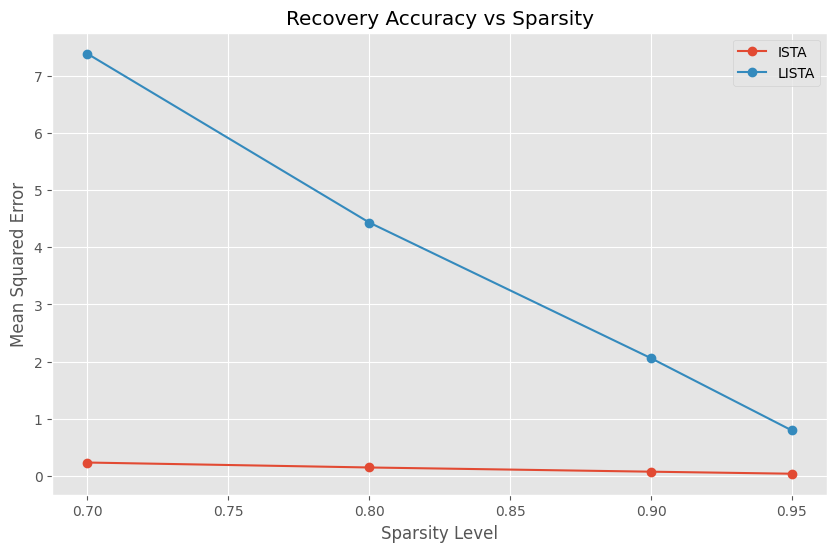

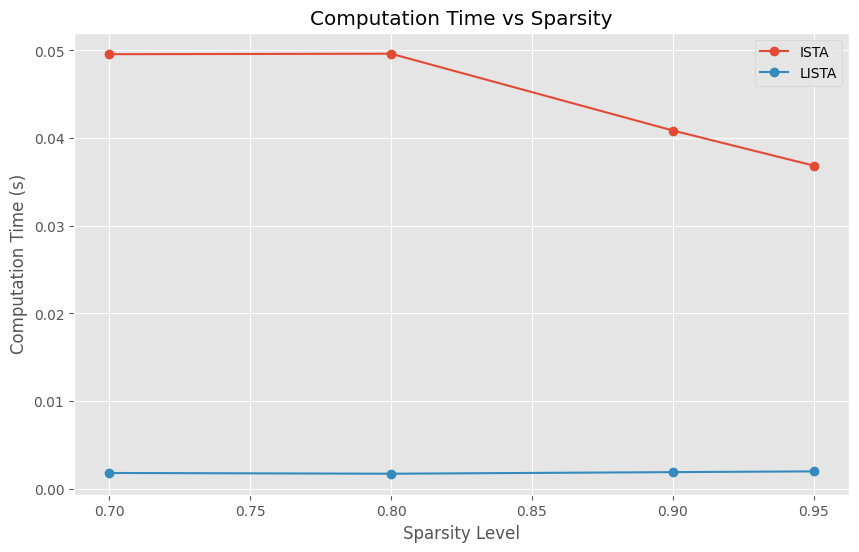


Sparsity Level: 0.7

Sparsity Level: 0.8

Sparsity Level: 0.9

Sparsity Level: 0.95


In [43]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import time


class SparseVectorGenerator:
    """Generates sparse vectors with specified size and sparsity level."""
    
    def __init__(self, size, sparsity_level):
        self.size = size
        self.sparsity_level = sparsity_level

    def generate(self):
        """Generates a sparse vector."""
        z = np.zeros(self.size)
        num_nonzero_elements = int(self.size * (1 - self.sparsity_level))
        indices = np.random.choice(self.size, num_nonzero_elements, replace=False)
        z[indices] = np.random.randn(num_nonzero_elements)
        return z

class EnhancedConvergenceComparator:
    def __init__(self, A, ista, lista_model, max_iter, alpha, sparsity_levels, num_samples):
        self.A = A
        self.ista = ista
        self.lista_model = lista_model
        self.max_iter = max_iter
        self.alpha = alpha
        self.sparsity_levels = sparsity_levels
        self.num_samples = num_samples

    def compare(self):
        device = next(self.lista_model.parameters()).device
        A_tensor = torch.tensor(self.A, device=device).float()
        
        results = {sparsity: {'ista': [], 'lista': []} for sparsity in self.sparsity_levels}
        
        for sparsity in self.sparsity_levels:
            for _ in range(self.num_samples):
                z_true = SparseVectorGenerator(self.A.shape[1], sparsity).generate()
                x = self.A @ z_true
                
                # ISTA
                start_time = time.time()
                z_ista = self.ista.optimize(self.A, x, alpha=self.alpha)
                ista_time = time.time() - start_time
                ista_loss_history = self.ista.loss_history_combined
                ista_mse = np.mean((z_ista - z_true)**2)
                ista_sparsity = np.count_nonzero(z_ista) / len(z_ista)
                
                # LISTA
                start_time = time.time()
                with torch.no_grad():
                    x_tensor = torch.tensor(x).float().to(device)
                    z_lista = self.lista_model(x_tensor).cpu().numpy()
                lista_time = time.time() - start_time
                lista_loss = nn.L1Loss()(torch.tensor(x).float().to(device), 
                                         A_tensor @ torch.tensor(z_lista).float().to(device)).item()
                lista_mse = np.mean((z_lista - z_true)**2)
                lista_sparsity = np.count_nonzero(z_lista) / len(z_lista)
                
                results[sparsity]['ista'].append({
                    'loss_history': ista_loss_history,
                    'final_loss': ista_loss_history[-1],
                    'mse': ista_mse,
                    'sparsity': ista_sparsity,
                    'time': ista_time
                })
                results[sparsity]['lista'].append({
                    'final_loss': lista_loss,
                    'mse': lista_mse,
                    'sparsity': lista_sparsity,
                    'time': lista_time
                })
        
        self.plot_results(results)
        self.print_summary(results)

    def plot_results(self, results):
        plt.style.use("ggplot")
        
        # Final Loss vs Sparsity plot
        plt.figure(figsize=(10, 6))
        ista_losses = [np.mean([r['final_loss'] for r in results[s]['ista']]) for s in self.sparsity_levels]
        lista_losses = [np.mean([r['final_loss'] for r in results[s]['lista']]) for s in self.sparsity_levels]
        plt.plot(self.sparsity_levels, ista_losses, marker='o', label='ISTA')
        plt.plot(self.sparsity_levels, lista_losses, marker='o', label='LISTA')
        plt.title('Final Loss vs Sparsity')
        plt.xlabel('Sparsity Level')
        plt.ylabel('Final Loss')
        plt.legend()
        plt.show()
        
        # MSE vs Sparsity plot
        plt.figure(figsize=(10, 6))
        ista_mses = [np.mean([r['mse'] for r in results[s]['ista']]) for s in self.sparsity_levels]
        lista_mses = [np.mean([r['mse'] for r in results[s]['lista']]) for s in self.sparsity_levels]
        plt.plot(self.sparsity_levels, ista_mses, marker='o', label='ISTA')
        plt.plot(self.sparsity_levels, lista_mses, marker='o', label='LISTA')
        plt.title('Recovery Accuracy vs Sparsity')
        plt.xlabel('Sparsity Level')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.show()
        
        # Computation Time vs Sparsity plot
        plt.figure(figsize=(10, 6))
        ista_times = [np.mean([r['time'] for r in results[s]['ista']]) for s in self.sparsity_levels]
        lista_times = [np.mean([r['time'] for r in results[s]['lista']]) for s in self.sparsity_levels]
        plt.plot(self.sparsity_levels, ista_times, marker='o', label='ISTA')
        plt.plot(self.sparsity_levels, lista_times, marker='o', label='LISTA')
        plt.title('Computation Time vs Sparsity')
        plt.xlabel('Sparsity Level')
        plt.ylabel('Computation Time (s)')
        plt.legend()
        plt.show()

    def print_summary(self, results):
        for sparsity in self.sparsity_levels:
            print(f"\nSparsity Level: {sparsity}")
            ista_loss = np.mean([r['final_loss'] for r in results[sparsity]['ista']])
            lista_loss = np.mean([r['final_loss'] for r in results[sparsity]['lista']])
            ista_mse = np.mean([r['mse'] for r in results[sparsity]['ista']])
            lista_mse = np.mean([r['mse'] for r in results[sparsity]['lista']])
            ista_time = np.mean([r['time'] for r in results[sparsity]['ista']])
            lista_time = np.mean([r['time'] for r in results[sparsity]['lista']])
            ista_sparsity = np.mean([r['sparsity'] for r in results[sparsity]['ista']])
            lista_sparsity = np.mean([r['sparsity'] for r in results[sparsity]['lista']])
            
#             print(f"  ISTA  - Loss: {ista_loss:.4f}, MSE: {ista_mse:.4f}, Time: {ista_time:.4f}s, Achieved Sparsity: {ista_sparsity:.4f}")
#             print(f"  LISTA - Loss: {lista_loss:.4f}, MSE: {lista_mse:.4f}, Time: {lista_time:.4f}s, Achieved Sparsity: {lista_sparsity:.4f}")
            


# Usage
n = 100
A = np.random.randn(n, n)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 50
ista = ISTA(lambd=2.0, max_iter=3000)
model_unfolded.eval()
sparsity_levels = [0.7, 0.8, 0.9, 0.95]
comparator = EnhancedConvergenceComparator(A, ista, model_unfolded, max_iter=3000, alpha=alpha, sparsity_levels=sparsity_levels, num_samples=50)
comparator.compare()

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [3]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [4]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [5]:
# DO NOT MODIFY
filename = "/kaggle/input/dataset/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])


Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)
Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original


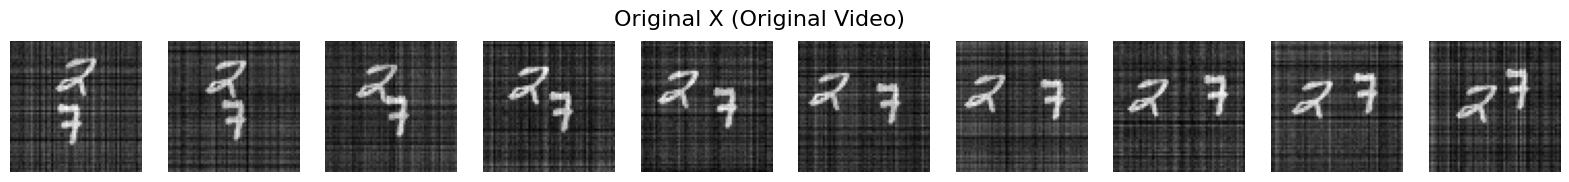

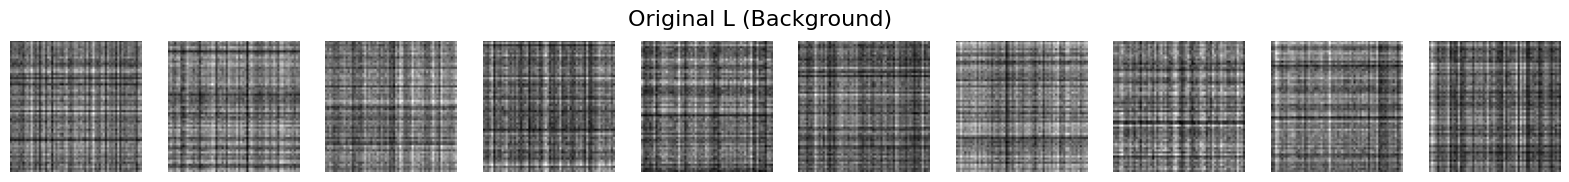

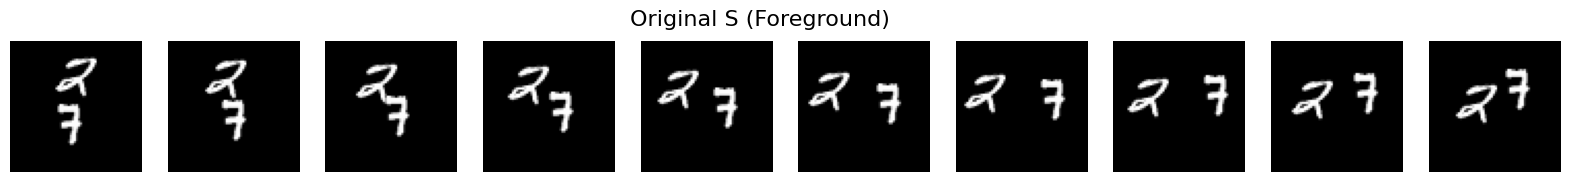



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [6]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (or frame, since there is no video sequence)
    
    # Directly access the first frame for all sequences
    frames = data[video_idx:video_idx+10]  # Take the first 10 frames
    
    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()
    
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  

print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        super(ISTABlock, self).__init__()
        self.branch = branch
        if self.branch == 'L':
            self.conv1 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.conv2 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.conv3 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
        elif self.branch == 'S':
            self.conv1 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.conv2 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.conv3 = nn.Conv2d(1, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.threshold = nn.Parameter(torch.tensor(0.1))

    def _soft(self, X, thr):
        return torch.sign(X) * F.relu(torch.abs(X) - thr)

    def _svt(self, X, thr):
        B, C, H, W = X.size()
        X = X.view(B*C, H*W)
        U, S, V = torch.svd(X)
        S = F.relu(S - thr)
        return torch.mm(torch.mm(U, torch.diag(S)), V.t()).view(B, C, H, W)

    def forward(self, L, S, X):
        if self.branch == 'L':
            Y = self.conv1(L) + self.conv2(S) + self.conv3(X)
            return self._svt(Y, self.threshold)
        elif self.branch == 'S':
            Y = self.conv1(L) + self.conv2(S) + self.conv3(X)
            return self._soft(Y, self.threshold)
        else:
            raise ValueError("Branch must be either 'S' or 'L'")

class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        super(UnfoldedDNN, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(configs["num_layers"]):
            self.layers.append(nn.ModuleDict({
                'S': ISTABlock('S', configs["kernel_size"]),
                'L': ISTABlock('L', configs["kernel_size"])
            }))

    def get_thresholds(self):
        thresholds_S = [layer['S'].threshold.item() for layer in self.layers]
        thresholds_L = [layer['L'].threshold.item() for layer in self.layers]
        return thresholds_S, thresholds_L

    def forward(self, X):
        L = torch.zeros_like(X)
        S = torch.zeros_like(X)
        activations_L = []
        activations_S = []
        for layer in self.layers:
            L = layer['L'](L, S, X)
            S = layer['S'](L, S, X)
            activations_L.append(L)
            activations_S.append(S)
        return (activations_L, activations_S), (L, S)

Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [9]:
def plot_mse_loss(epoch_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MSE Loss over Epochs')
    plt.show()

def plot_threshold_params(L_params, S_params):
    
    layers = np.arange(1, len(L_params[0]) + 1)
    plt.figure(figsize=(10, 5))

    plt.plot(layers, L_params[0], marker='o', label='L Params', color='blue')
    plt.plot(layers, S_params[0], marker='o', label='S Params', color='orange')

    plt.xlabel('Layers')
    plt.ylabel('Threshold Values')
    plt.title('Threshold Parameters Across Layers')
    plt.xticks(layers)  
    plt.legend()  
    plt.grid(True)  
    plt.tight_layout()
    plt.show()

def get_singular_values(L_):
    _, S, _ = torch.svd(L_.squeeze())
    return S.cpu().numpy()

def get_sparsity(S_, tol=1e-6):
    return torch.sum(torch.abs(S_) > tol).item() 

def plot_singular_values_over_layers(singular_values):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(range(1, len(singular_values) + 1), range(1, len(singular_values[0]) + 1))
    Z = np.array(singular_values).T
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    
    ax.set_xlabel('Layer')
    ax.set_ylabel('Index of Singular Value')
    ax.set_zlabel('Singular Value')
    ax.set_title('Singular Values across Layers')
    
    fig.colorbar(surf)
    plt.show()

def plot_sparse_values_over_layers(sparse_values):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(sparse_values) + 1), sparse_values, 'go-')
    plt.xlabel('Layer')
    plt.ylabel('Average Number of Sparse Values')
    plt.title('Sparsity across Layers')
    plt.show()


In [10]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
            (activations_L, activations_S), (L_ , S_)= model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in batch {batch_idx}")
            plot_first_frame(L, S, X, L_, S_)  # Include predicted L_ and S_

            batch_singular_values = []
            batch_sparsities = []
            layer_idx = 0
            for L_layer, S_layer in zip(activations_L, activations_S):
                layer_idx += 1
                singular_values = get_singular_values(L_layer)
                sparsity = get_sparsity(S_layer) / S_layer.numel()
                singular_values = pad_or_truncate(singular_values, target_length=32)
                batch_singular_values.append(singular_values)
                batch_sparsities.append(sparsity)

            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")
    
    avg_singular_values = np.mean(all_singular_values, axis=0)
    avg_singular_values = np.squeeze(np.mean(avg_singular_values, axis=1))
    print(avg_singular_values.shape)
    avg_sparsities = np.mean(all_sparsities, axis=0)

    plot_singular_values_over_layers(avg_singular_values)
    print("\n")
    plot_sparse_values_over_layers(avg_sparsities)
    return avg_loss




def plot_first_frame(L, S, X, L_pred, S_pred):
    L_frame_flat = L[0, 0, :, 0]      # Ground truth L
    S_frame_flat = S[0, 0, :, 0]      # Ground truth S
    X_frame_flat = X[0, 0, :, 0]      # Original image D (X)
    
    L_pred_frame_flat = L_pred[0, 0, :, 0]  # Predicted L
    S_pred_frame_flat = S_pred[0, 0, :, 0]  # Predicted S
    X_pred_frame_flat = (L_pred + S_pred)[0, 0, :, 0]  # Predicted X (L_pred + S_pred)

    # Reshape into 64x64 images
    L_frame = L_frame_flat.view(64, 64).cpu().numpy()
    S_frame = S_frame_flat.view(64, 64).cpu().numpy()
    X_frame = X_frame_flat.view(64, 64).cpu().numpy()

    L_pred_frame = L_pred_frame_flat.view(64, 64).cpu().numpy()
    S_pred_frame = S_pred_frame_flat.view(64, 64).cpu().numpy()
    X_pred_frame = X_pred_frame_flat.view(64, 64).cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    # Ground truth plots
    axs[0, 0].imshow(L_frame, cmap='gray')
    axs[0, 0].set_title('Ground Truth Background (L)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(S_frame, cmap='gray')
    axs[0, 1].set_title('Ground Truth Foreground (S)')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(X_frame, cmap='gray')
    axs[0, 2].set_title('Ground Truth Original (D)')
    axs[0, 2].axis('off')

    # Predicted plots
    axs[1, 0].imshow(L_pred_frame, cmap='gray')
    axs[1, 0].set_title('Predicted Background (L_pred)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(S_pred_frame, cmap='gray')
    axs[1, 1].set_title('Predicted Foreground (S_pred)')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(X_pred_frame, cmap='gray')
    axs[1, 2].set_title('Predicted Original (L_pred + S_pred)')
    axs[1, 2].axis('off')

    plt.show()



def loss_fn(L_, S_, L, S, X):
  loss_L = torch.nn.functional.mse_loss(L_, L)
  loss_S = torch.nn.functional.mse_loss(S_, S)
  return loss_L + loss_S

def pad_or_truncate(tensor, target_length, pad_value=0):
    """
    Pads or truncates a tensor along the first dimension (batch size).
    If the tensor is shorter, pad with ⁠ pad_value ⁠ in a way that preserves the tensor's dimensions.
    If the tensor is longer, truncate it.
    """
    length = tensor.shape[0]
    
    if length < target_length:
        padding_shape = (target_length - length,) + tensor.shape[1:]
        padding = np.full(padding_shape, pad_value)
        
        return np.concatenate([tensor, padding], axis=0)
    
    elif length > target_length:
        return tensor[:target_length]
    
    return tensor






Epoch [1/250]: 100%|██████████| 25/25 [00:03<00:00,  6.37batch/s, loss=0.306]


Epoch: [1/250], Loss: 0.3060


Epoch [2/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.291]


Epoch: [2/250], Loss: 0.2911


Epoch [3/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.276]


Epoch: [3/250], Loss: 0.2762


Epoch [4/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.261]


Epoch: [4/250], Loss: 0.2606


Epoch [5/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.244] 


Epoch: [5/250], Loss: 0.2437


Epoch [6/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.224] 


Epoch: [6/250], Loss: 0.2242


Epoch [7/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.199] 


Epoch: [7/250], Loss: 0.1986


Epoch [8/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.162] 


Epoch: [8/250], Loss: 0.1625


Epoch [9/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.124] 


Epoch: [9/250], Loss: 0.1236


Epoch [10/250]: 100%|██████████| 25/25 [00:02<00:00,  8.59batch/s, loss=0.0958]


Epoch: [10/250], Loss: 0.0958


Epoch [11/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0798]


Epoch: [11/250], Loss: 0.0798


Epoch [12/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0716]


Epoch: [12/250], Loss: 0.0716


Epoch [13/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0673]


Epoch: [13/250], Loss: 0.0673


Epoch [14/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0651]


Epoch: [14/250], Loss: 0.0651


Epoch [15/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0639]


Epoch: [15/250], Loss: 0.0639


Epoch [16/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0629]


Epoch: [16/250], Loss: 0.0629


Epoch [17/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0621]


Epoch: [17/250], Loss: 0.0621


Epoch [18/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0613]


Epoch: [18/250], Loss: 0.0613


Epoch [19/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0606]


Epoch: [19/250], Loss: 0.0606


Epoch [20/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0598]


Epoch: [20/250], Loss: 0.0598


Epoch [21/250]: 100%|██████████| 25/25 [00:02<00:00,  8.67batch/s, loss=0.0591]


Epoch: [21/250], Loss: 0.0591


Epoch [22/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0584]


Epoch: [22/250], Loss: 0.0584


Epoch [23/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0577]


Epoch: [23/250], Loss: 0.0577


Epoch [24/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.057] 


Epoch: [24/250], Loss: 0.0570


Epoch [25/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0563]


Epoch: [25/250], Loss: 0.0563


Epoch [26/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0557]


Epoch: [26/250], Loss: 0.0557


Epoch [27/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0551]


Epoch: [27/250], Loss: 0.0551


Epoch [28/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0544]


Epoch: [28/250], Loss: 0.0544


Epoch [29/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0538]


Epoch: [29/250], Loss: 0.0538


Epoch [30/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0532]


Epoch: [30/250], Loss: 0.0532


Epoch [31/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0527]


Epoch: [31/250], Loss: 0.0527


Epoch [32/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0521]


Epoch: [32/250], Loss: 0.0521


Epoch [33/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0515]


Epoch: [33/250], Loss: 0.0515


Epoch [34/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.051] 


Epoch: [34/250], Loss: 0.0510


Epoch [35/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0505]


Epoch: [35/250], Loss: 0.0505


Epoch [36/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.05]  


Epoch: [36/250], Loss: 0.0500


Epoch [37/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0495]


Epoch: [37/250], Loss: 0.0495


Epoch [38/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.049] 


Epoch: [38/250], Loss: 0.0490


Epoch [39/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0485]


Epoch: [39/250], Loss: 0.0485


Epoch [40/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.048] 


Epoch: [40/250], Loss: 0.0480


Epoch [41/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0476]


Epoch: [41/250], Loss: 0.0476


Epoch [42/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0471]


Epoch: [42/250], Loss: 0.0471


Epoch [43/250]: 100%|██████████| 25/25 [00:02<00:00,  8.69batch/s, loss=0.0467]


Epoch: [43/250], Loss: 0.0467


Epoch [44/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0463]


Epoch: [44/250], Loss: 0.0463


Epoch [45/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0459]


Epoch: [45/250], Loss: 0.0459


Epoch [46/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0454]


Epoch: [46/250], Loss: 0.0454


Epoch [47/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0451]


Epoch: [47/250], Loss: 0.0451


Epoch [48/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0447]


Epoch: [48/250], Loss: 0.0447


Epoch [49/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0443]


Epoch: [49/250], Loss: 0.0443


Epoch [50/250]: 100%|██████████| 25/25 [00:02<00:00,  8.71batch/s, loss=0.0439]


Epoch: [50/250], Loss: 0.0439


Epoch [51/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0436]


Epoch: [51/250], Loss: 0.0436


Epoch [52/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0432]


Epoch: [52/250], Loss: 0.0432


Epoch [53/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0429]


Epoch: [53/250], Loss: 0.0429


Epoch [54/250]: 100%|██████████| 25/25 [00:02<00:00,  8.63batch/s, loss=0.0425]


Epoch: [54/250], Loss: 0.0425


Epoch [55/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0422]


Epoch: [55/250], Loss: 0.0422


Epoch [56/250]: 100%|██████████| 25/25 [00:02<00:00,  8.73batch/s, loss=0.0419]


Epoch: [56/250], Loss: 0.0419


Epoch [57/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0415]


Epoch: [57/250], Loss: 0.0415


Epoch [58/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0412]


Epoch: [58/250], Loss: 0.0412


Epoch [59/250]: 100%|██████████| 25/25 [00:02<00:00,  8.68batch/s, loss=0.0409]


Epoch: [59/250], Loss: 0.0409


Epoch [60/250]: 100%|██████████| 25/25 [00:02<00:00,  8.71batch/s, loss=0.0406]


Epoch: [60/250], Loss: 0.0406


Epoch [61/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0403]


Epoch: [61/250], Loss: 0.0403


Epoch [62/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.04]  


Epoch: [62/250], Loss: 0.0400


Epoch [63/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0397]


Epoch: [63/250], Loss: 0.0397


Epoch [64/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0394]


Epoch: [64/250], Loss: 0.0394


Epoch [65/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0391]


Epoch: [65/250], Loss: 0.0391


Epoch [66/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0389]


Epoch: [66/250], Loss: 0.0389


Epoch [67/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.0386]


Epoch: [67/250], Loss: 0.0386


Epoch [68/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0383]


Epoch: [68/250], Loss: 0.0383


Epoch [69/250]: 100%|██████████| 25/25 [00:02<00:00,  8.73batch/s, loss=0.038] 


Epoch: [69/250], Loss: 0.0380


Epoch [70/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0378]


Epoch: [70/250], Loss: 0.0378


Epoch [71/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0375]


Epoch: [71/250], Loss: 0.0375


Epoch [72/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0372]


Epoch: [72/250], Loss: 0.0372


Epoch [73/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.037] 


Epoch: [73/250], Loss: 0.0370


Epoch [74/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0367]


Epoch: [74/250], Loss: 0.0367


Epoch [75/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0365]


Epoch: [75/250], Loss: 0.0365


Epoch [76/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0362]


Epoch: [76/250], Loss: 0.0362


Epoch [77/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0359]


Epoch: [77/250], Loss: 0.0359


Epoch [78/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0357]


Epoch: [78/250], Loss: 0.0357


Epoch [79/250]: 100%|██████████| 25/25 [00:02<00:00,  8.88batch/s, loss=0.0354]


Epoch: [79/250], Loss: 0.0354


Epoch [80/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0352]


Epoch: [80/250], Loss: 0.0352


Epoch [81/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.0349]


Epoch: [81/250], Loss: 0.0349


Epoch [82/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0347]


Epoch: [82/250], Loss: 0.0347


Epoch [83/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0344]


Epoch: [83/250], Loss: 0.0344


Epoch [84/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0342]


Epoch: [84/250], Loss: 0.0342


Epoch [85/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.034] 


Epoch: [85/250], Loss: 0.0340


Epoch [86/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0337]


Epoch: [86/250], Loss: 0.0337


Epoch [87/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0335]


Epoch: [87/250], Loss: 0.0335


Epoch [88/250]: 100%|██████████| 25/25 [00:02<00:00,  8.67batch/s, loss=0.0332]


Epoch: [88/250], Loss: 0.0332


Epoch [89/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.033] 


Epoch: [89/250], Loss: 0.0330


Epoch [90/250]: 100%|██████████| 25/25 [00:02<00:00,  8.71batch/s, loss=0.0327]


Epoch: [90/250], Loss: 0.0327


Epoch [91/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0325]


Epoch: [91/250], Loss: 0.0325


Epoch [92/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.0323]


Epoch: [92/250], Loss: 0.0323


Epoch [93/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.032] 


Epoch: [93/250], Loss: 0.0320


Epoch [94/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0318]


Epoch: [94/250], Loss: 0.0318


Epoch [95/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0316]


Epoch: [95/250], Loss: 0.0316


Epoch [96/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0314]


Epoch: [96/250], Loss: 0.0314


Epoch [97/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0311]


Epoch: [97/250], Loss: 0.0311


Epoch [98/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0309]


Epoch: [98/250], Loss: 0.0309


Epoch [99/250]: 100%|██████████| 25/25 [00:02<00:00,  8.69batch/s, loss=0.0307]


Epoch: [99/250], Loss: 0.0307


Epoch [100/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0305]


Epoch: [100/250], Loss: 0.0305


Epoch [101/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0303]


Epoch: [101/250], Loss: 0.0303


Epoch [102/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0301]


Epoch: [102/250], Loss: 0.0301


Epoch [103/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0299]


Epoch: [103/250], Loss: 0.0299


Epoch [104/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0297]


Epoch: [104/250], Loss: 0.0297


Epoch [105/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0296]


Epoch: [105/250], Loss: 0.0296


Epoch [106/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0294]


Epoch: [106/250], Loss: 0.0294


Epoch [107/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0292]


Epoch: [107/250], Loss: 0.0292


Epoch [108/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.029] 


Epoch: [108/250], Loss: 0.0290


Epoch [109/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0288]


Epoch: [109/250], Loss: 0.0288


Epoch [110/250]: 100%|██████████| 25/25 [00:02<00:00,  8.66batch/s, loss=0.0286]


Epoch: [110/250], Loss: 0.0286


Epoch [111/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0284]


Epoch: [111/250], Loss: 0.0284


Epoch [112/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0282]


Epoch: [112/250], Loss: 0.0282


Epoch [113/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.028] 


Epoch: [113/250], Loss: 0.0280


Epoch [114/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0278]


Epoch: [114/250], Loss: 0.0278


Epoch [115/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0277]


Epoch: [115/250], Loss: 0.0277


Epoch [116/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0275]


Epoch: [116/250], Loss: 0.0275


Epoch [117/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0273]


Epoch: [117/250], Loss: 0.0273


Epoch [118/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0271]


Epoch: [118/250], Loss: 0.0271


Epoch [119/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0269]


Epoch: [119/250], Loss: 0.0269


Epoch [120/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0267]


Epoch: [120/250], Loss: 0.0267


Epoch [121/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0265]


Epoch: [121/250], Loss: 0.0265


Epoch [122/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0264]


Epoch: [122/250], Loss: 0.0264


Epoch [123/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0262]


Epoch: [123/250], Loss: 0.0262


Epoch [124/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.026] 


Epoch: [124/250], Loss: 0.0260


Epoch [125/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0258]


Epoch: [125/250], Loss: 0.0258


Epoch [126/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0256]


Epoch: [126/250], Loss: 0.0256


Epoch [127/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0254]


Epoch: [127/250], Loss: 0.0254


Epoch [128/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0252]


Epoch: [128/250], Loss: 0.0252


Epoch [129/250]: 100%|██████████| 25/25 [00:02<00:00,  8.76batch/s, loss=0.0251] 


Epoch: [129/250], Loss: 0.0251


Epoch [130/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0249] 


Epoch: [130/250], Loss: 0.0249


Epoch [131/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0247] 


Epoch: [131/250], Loss: 0.0247


Epoch [132/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0245] 


Epoch: [132/250], Loss: 0.0245


Epoch [133/250]: 100%|██████████| 25/25 [00:02<00:00,  8.73batch/s, loss=0.0243] 


Epoch: [133/250], Loss: 0.0243


Epoch [134/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0241] 


Epoch: [134/250], Loss: 0.0241


Epoch [135/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0239] 


Epoch: [135/250], Loss: 0.0239


Epoch [136/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0237] 


Epoch: [136/250], Loss: 0.0237


Epoch [137/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0235] 


Epoch: [137/250], Loss: 0.0235


Epoch [138/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0233] 


Epoch: [138/250], Loss: 0.0233


Epoch [139/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0231] 


Epoch: [139/250], Loss: 0.0231


Epoch [140/250]: 100%|██████████| 25/25 [00:02<00:00,  8.69batch/s, loss=0.0229] 


Epoch: [140/250], Loss: 0.0229


Epoch [141/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0227] 


Epoch: [141/250], Loss: 0.0227


Epoch [142/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0225] 


Epoch: [142/250], Loss: 0.0225


Epoch [143/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0223] 


Epoch: [143/250], Loss: 0.0223


Epoch [144/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0221] 


Epoch: [144/250], Loss: 0.0221


Epoch [145/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0219] 


Epoch: [145/250], Loss: 0.0219


Epoch [146/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0217] 


Epoch: [146/250], Loss: 0.0217


Epoch [147/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0215] 


Epoch: [147/250], Loss: 0.0215


Epoch [148/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0213] 


Epoch: [148/250], Loss: 0.0213


Epoch [149/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0211] 


Epoch: [149/250], Loss: 0.0211


Epoch [150/250]: 100%|██████████| 25/25 [00:02<00:00,  8.74batch/s, loss=0.0209] 


Epoch: [150/250], Loss: 0.0209


Epoch [151/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0207] 


Epoch: [151/250], Loss: 0.0207


Epoch [152/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.0205] 


Epoch: [152/250], Loss: 0.0205


Epoch [153/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0203] 


Epoch: [153/250], Loss: 0.0203


Epoch [154/250]: 100%|██████████| 25/25 [00:02<00:00,  8.73batch/s, loss=0.0201] 


Epoch: [154/250], Loss: 0.0201


Epoch [155/250]: 100%|██████████| 25/25 [00:02<00:00,  8.54batch/s, loss=0.0199] 


Epoch: [155/250], Loss: 0.0199


Epoch [156/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0197] 


Epoch: [156/250], Loss: 0.0197


Epoch [157/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0196] 


Epoch: [157/250], Loss: 0.0196


Epoch [158/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0194] 


Epoch: [158/250], Loss: 0.0194


Epoch [159/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0192] 


Epoch: [159/250], Loss: 0.0192


Epoch [160/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0191] 


Epoch: [160/250], Loss: 0.0191


Epoch [161/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.0189] 


Epoch: [161/250], Loss: 0.0189


Epoch [162/250]: 100%|██████████| 25/25 [00:02<00:00,  8.75batch/s, loss=0.0188] 


Epoch: [162/250], Loss: 0.0188


Epoch [163/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0187] 


Epoch: [163/250], Loss: 0.0187


Epoch [164/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0186] 


Epoch: [164/250], Loss: 0.0186


Epoch [165/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0184] 


Epoch: [165/250], Loss: 0.0184


Epoch [166/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0183] 


Epoch: [166/250], Loss: 0.0183


Epoch [167/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0182] 


Epoch: [167/250], Loss: 0.0182


Epoch [168/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0181] 


Epoch: [168/250], Loss: 0.0181


Epoch [169/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.018]  


Epoch: [169/250], Loss: 0.0180


Epoch [170/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.0179] 


Epoch: [170/250], Loss: 0.0179


Epoch [171/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0178] 


Epoch: [171/250], Loss: 0.0178


Epoch [172/250]: 100%|██████████| 25/25 [00:02<00:00,  8.88batch/s, loss=0.0177] 


Epoch: [172/250], Loss: 0.0177


Epoch [173/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0177] 


Epoch: [173/250], Loss: 0.0177


Epoch [174/250]: 100%|██████████| 25/25 [00:02<00:00,  8.79batch/s, loss=0.0176] 


Epoch: [174/250], Loss: 0.0176


Epoch [175/250]: 100%|██████████| 25/25 [00:02<00:00,  8.78batch/s, loss=0.0175] 


Epoch: [175/250], Loss: 0.0175


Epoch [176/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0174] 


Epoch: [176/250], Loss: 0.0174


Epoch [177/250]: 100%|██████████| 25/25 [00:02<00:00,  8.70batch/s, loss=0.0173] 


Epoch: [177/250], Loss: 0.0173


Epoch [178/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0172] 


Epoch: [178/250], Loss: 0.0172


Epoch [179/250]: 100%|██████████| 25/25 [00:02<00:00,  8.81batch/s, loss=0.0172] 


Epoch: [179/250], Loss: 0.0172


Epoch [180/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0171] 


Epoch: [180/250], Loss: 0.0171


Epoch [181/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.017]  


Epoch: [181/250], Loss: 0.0170


Epoch [182/250]: 100%|██████████| 25/25 [00:02<00:00,  8.84batch/s, loss=0.0169] 


Epoch: [182/250], Loss: 0.0169


Epoch [183/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0169] 


Epoch: [183/250], Loss: 0.0169


Epoch [184/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0168] 


Epoch: [184/250], Loss: 0.0168


Epoch [185/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0167] 


Epoch: [185/250], Loss: 0.0167


Epoch [186/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0167] 


Epoch: [186/250], Loss: 0.0167


Epoch [187/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0166] 


Epoch: [187/250], Loss: 0.0166


Epoch [188/250]: 100%|██████████| 25/25 [00:02<00:00,  8.80batch/s, loss=0.0166] 


Epoch: [188/250], Loss: 0.0166


Epoch [189/250]: 100%|██████████| 25/25 [00:02<00:00,  8.77batch/s, loss=0.0165] 


Epoch: [189/250], Loss: 0.0165


Epoch [190/250]: 100%|██████████| 25/25 [00:02<00:00,  8.85batch/s, loss=0.0164] 


Epoch: [190/250], Loss: 0.0164


Epoch [191/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0164] 


Epoch: [191/250], Loss: 0.0164


Epoch [192/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0163] 


Epoch: [192/250], Loss: 0.0163


Epoch [193/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0163] 


Epoch: [193/250], Loss: 0.0163


Epoch [194/250]: 100%|██████████| 25/25 [00:02<00:00,  8.98batch/s, loss=0.0162] 


Epoch: [194/250], Loss: 0.0162


Epoch [195/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0162] 


Epoch: [195/250], Loss: 0.0162


Epoch [196/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0161] 


Epoch: [196/250], Loss: 0.0161


Epoch [197/250]: 100%|██████████| 25/25 [00:02<00:00,  8.88batch/s, loss=0.0161] 


Epoch: [197/250], Loss: 0.0161


Epoch [198/250]: 100%|██████████| 25/25 [00:02<00:00,  8.96batch/s, loss=0.016]  


Epoch: [198/250], Loss: 0.0160


Epoch [199/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0159] 


Epoch: [199/250], Loss: 0.0159


Epoch [200/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.0159] 


Epoch: [200/250], Loss: 0.0159


Epoch [201/250]: 100%|██████████| 25/25 [00:02<00:00,  8.94batch/s, loss=0.0159] 


Epoch: [201/250], Loss: 0.0159


Epoch [202/250]: 100%|██████████| 25/25 [00:02<00:00,  8.98batch/s, loss=0.0158] 


Epoch: [202/250], Loss: 0.0158


Epoch [203/250]: 100%|██████████| 25/25 [00:02<00:00,  8.96batch/s, loss=0.0158] 


Epoch: [203/250], Loss: 0.0158


Epoch [204/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0157] 


Epoch: [204/250], Loss: 0.0157


Epoch [205/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0157] 


Epoch: [205/250], Loss: 0.0157


Epoch [206/250]: 100%|██████████| 25/25 [00:02<00:00,  8.96batch/s, loss=0.0156] 


Epoch: [206/250], Loss: 0.0156


Epoch [207/250]: 100%|██████████| 25/25 [00:02<00:00,  8.93batch/s, loss=0.0156] 


Epoch: [207/250], Loss: 0.0156


Epoch [208/250]: 100%|██████████| 25/25 [00:02<00:00,  8.95batch/s, loss=0.0155] 


Epoch: [208/250], Loss: 0.0155


Epoch [209/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0155] 


Epoch: [209/250], Loss: 0.0155


Epoch [210/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.0155] 


Epoch: [210/250], Loss: 0.0155


Epoch [211/250]: 100%|██████████| 25/25 [00:02<00:00,  8.72batch/s, loss=0.0154] 


Epoch: [211/250], Loss: 0.0154


Epoch [212/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.0154] 


Epoch: [212/250], Loss: 0.0154


Epoch [213/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0153] 


Epoch: [213/250], Loss: 0.0153


Epoch [214/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.0153] 


Epoch: [214/250], Loss: 0.0153


Epoch [215/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0152] 


Epoch: [215/250], Loss: 0.0152


Epoch [216/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0152] 


Epoch: [216/250], Loss: 0.0152


Epoch [217/250]: 100%|██████████| 25/25 [00:02<00:00,  8.94batch/s, loss=0.0152] 


Epoch: [217/250], Loss: 0.0152


Epoch [218/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0151] 


Epoch: [218/250], Loss: 0.0151


Epoch [219/250]: 100%|██████████| 25/25 [00:02<00:00,  8.94batch/s, loss=0.0151] 


Epoch: [219/250], Loss: 0.0151


Epoch [220/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.0151] 


Epoch: [220/250], Loss: 0.0151


Epoch [221/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.015]  


Epoch: [221/250], Loss: 0.0150


Epoch [222/250]: 100%|██████████| 25/25 [00:02<00:00,  8.82batch/s, loss=0.015]  


Epoch: [222/250], Loss: 0.0150


Epoch [223/250]: 100%|██████████| 25/25 [00:02<00:00,  8.93batch/s, loss=0.0149] 


Epoch: [223/250], Loss: 0.0149


Epoch [224/250]: 100%|██████████| 25/25 [00:02<00:00,  8.83batch/s, loss=0.0149] 


Epoch: [224/250], Loss: 0.0149


Epoch [225/250]: 100%|██████████| 25/25 [00:02<00:00,  8.98batch/s, loss=0.0149] 


Epoch: [225/250], Loss: 0.0149


Epoch [226/250]: 100%|██████████| 25/25 [00:02<00:00,  8.91batch/s, loss=0.0148] 


Epoch: [226/250], Loss: 0.0148


Epoch [227/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0148] 


Epoch: [227/250], Loss: 0.0148


Epoch [228/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.0148] 


Epoch: [228/250], Loss: 0.0148


Epoch [229/250]: 100%|██████████| 25/25 [00:02<00:00,  8.95batch/s, loss=0.0148] 


Epoch: [229/250], Loss: 0.0148


Epoch [230/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0147] 


Epoch: [230/250], Loss: 0.0147


Epoch [231/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0147] 


Epoch: [231/250], Loss: 0.0147


Epoch [232/250]: 100%|██████████| 25/25 [00:02<00:00,  8.95batch/s, loss=0.0146] 


Epoch: [232/250], Loss: 0.0146


Epoch [233/250]: 100%|██████████| 25/25 [00:02<00:00,  8.87batch/s, loss=0.0146] 


Epoch: [233/250], Loss: 0.0146


Epoch [234/250]: 100%|██████████| 25/25 [00:02<00:00,  8.88batch/s, loss=0.0146] 


Epoch: [234/250], Loss: 0.0146


Epoch [235/250]: 100%|██████████| 25/25 [00:02<00:00,  8.86batch/s, loss=0.0145] 


Epoch: [235/250], Loss: 0.0145


Epoch [236/250]: 100%|██████████| 25/25 [00:02<00:00,  8.94batch/s, loss=0.0145] 


Epoch: [236/250], Loss: 0.0145


Epoch [237/250]: 100%|██████████| 25/25 [00:02<00:00,  8.93batch/s, loss=0.0145] 


Epoch: [237/250], Loss: 0.0145


Epoch [238/250]: 100%|██████████| 25/25 [00:02<00:00,  9.01batch/s, loss=0.0145] 


Epoch: [238/250], Loss: 0.0145


Epoch [239/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0144] 


Epoch: [239/250], Loss: 0.0144


Epoch [240/250]: 100%|██████████| 25/25 [00:02<00:00,  8.96batch/s, loss=0.0144] 


Epoch: [240/250], Loss: 0.0144


Epoch [241/250]: 100%|██████████| 25/25 [00:02<00:00,  8.95batch/s, loss=0.0144] 


Epoch: [241/250], Loss: 0.0144


Epoch [242/250]: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, loss=0.0143] 


Epoch: [242/250], Loss: 0.0143


Epoch [243/250]: 100%|██████████| 25/25 [00:02<00:00,  8.96batch/s, loss=0.0143] 


Epoch: [243/250], Loss: 0.0143


Epoch [244/250]: 100%|██████████| 25/25 [00:02<00:00,  9.00batch/s, loss=0.0143] 


Epoch: [244/250], Loss: 0.0143


Epoch [245/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0143] 


Epoch: [245/250], Loss: 0.0143


Epoch [246/250]: 100%|██████████| 25/25 [00:02<00:00,  8.94batch/s, loss=0.0142] 


Epoch: [246/250], Loss: 0.0142


Epoch [247/250]: 100%|██████████| 25/25 [00:02<00:00,  8.97batch/s, loss=0.0142] 


Epoch: [247/250], Loss: 0.0142


Epoch [248/250]: 100%|██████████| 25/25 [00:02<00:00,  8.89batch/s, loss=0.0142] 


Epoch: [248/250], Loss: 0.0142


Epoch [249/250]: 100%|██████████| 25/25 [00:02<00:00,  8.92batch/s, loss=0.0142] 


Epoch: [249/250], Loss: 0.0142


Epoch [250/250]: 100%|██████████| 25/25 [00:02<00:00,  8.98batch/s, loss=0.0141] 


Epoch: [250/250], Loss: 0.0141


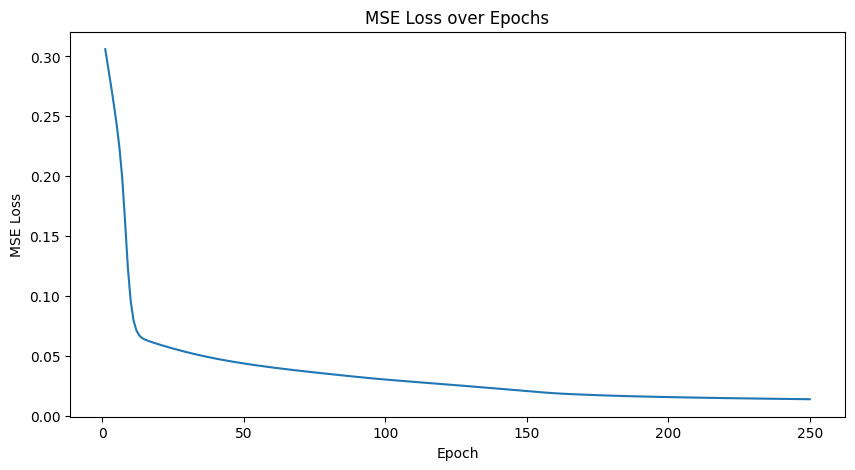

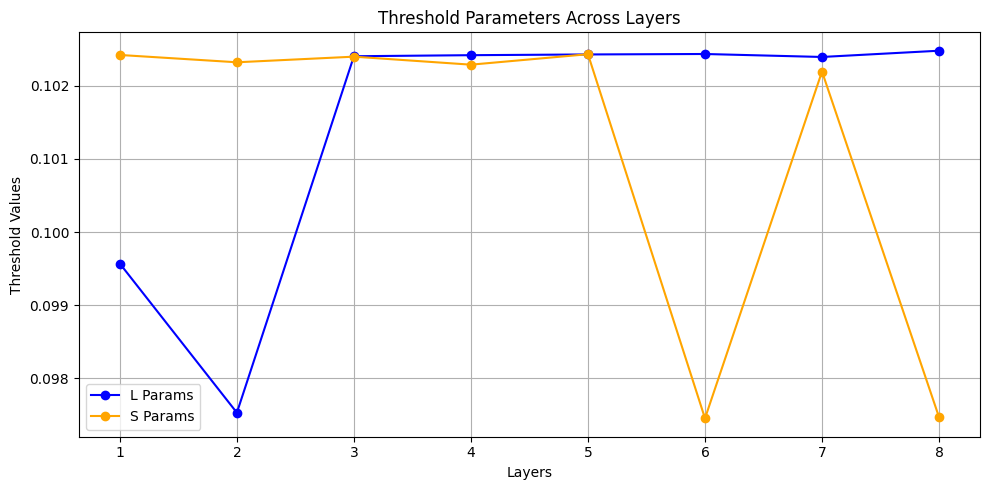

In [11]:
# Model and training configurations
# configs = {
#     "num_layers": 4,
#     "kernel_size": 3,
#     "lr": 1e-4,
#     "epochs": 30,
#     "batch_size": 32,
#     "device": "cuda" if torch.cuda.is_available() else "cpu"
# }
configs = {
    "num_layers": 8,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 250,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in batch 0


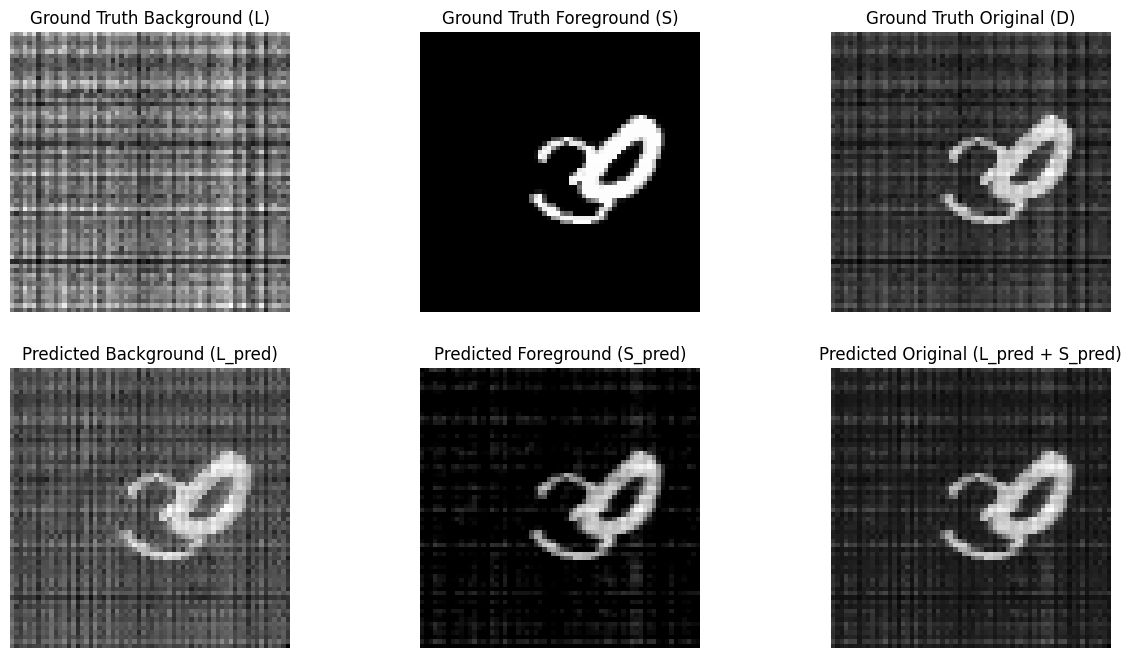

Plot for random frame in batch 1


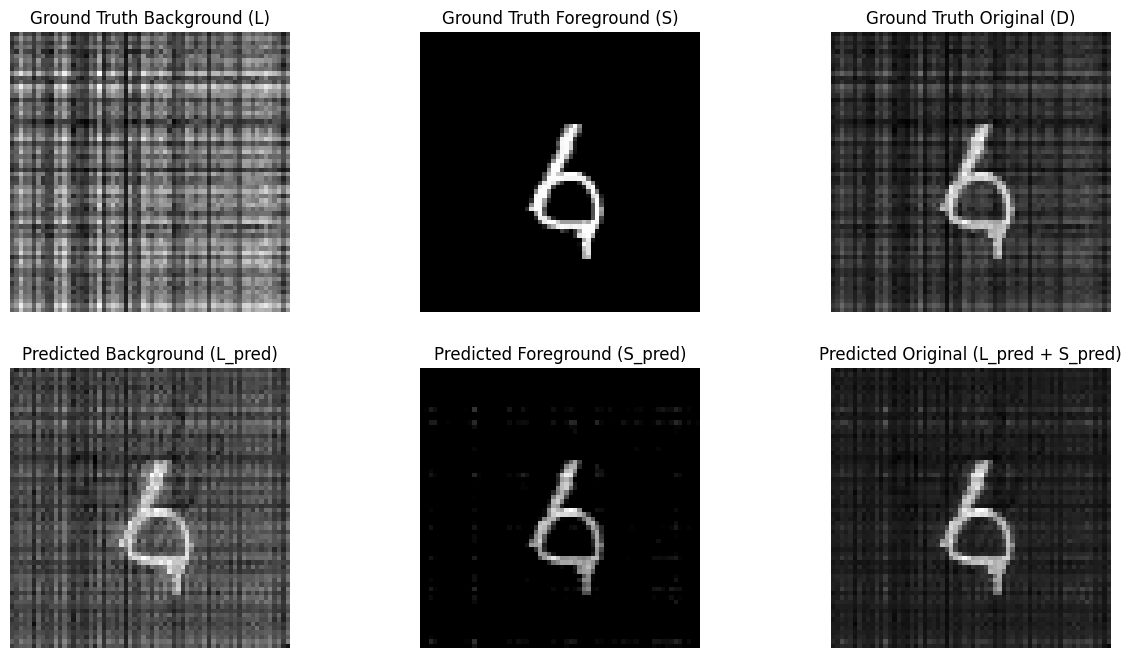

Plot for random frame in batch 2


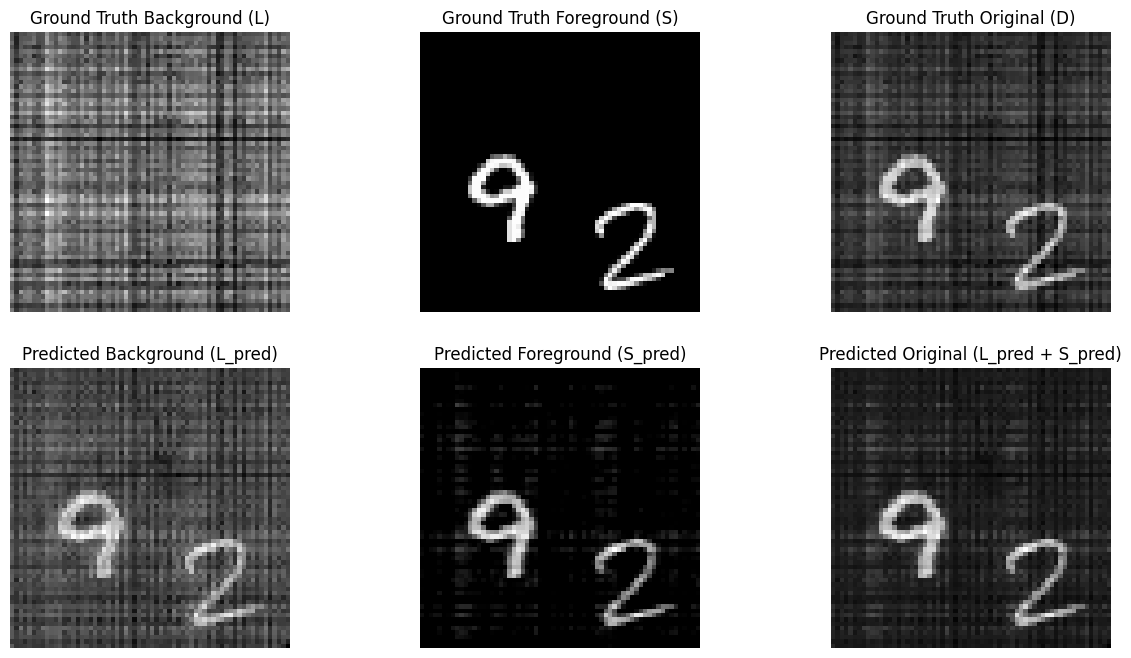

Plot for random frame in batch 3


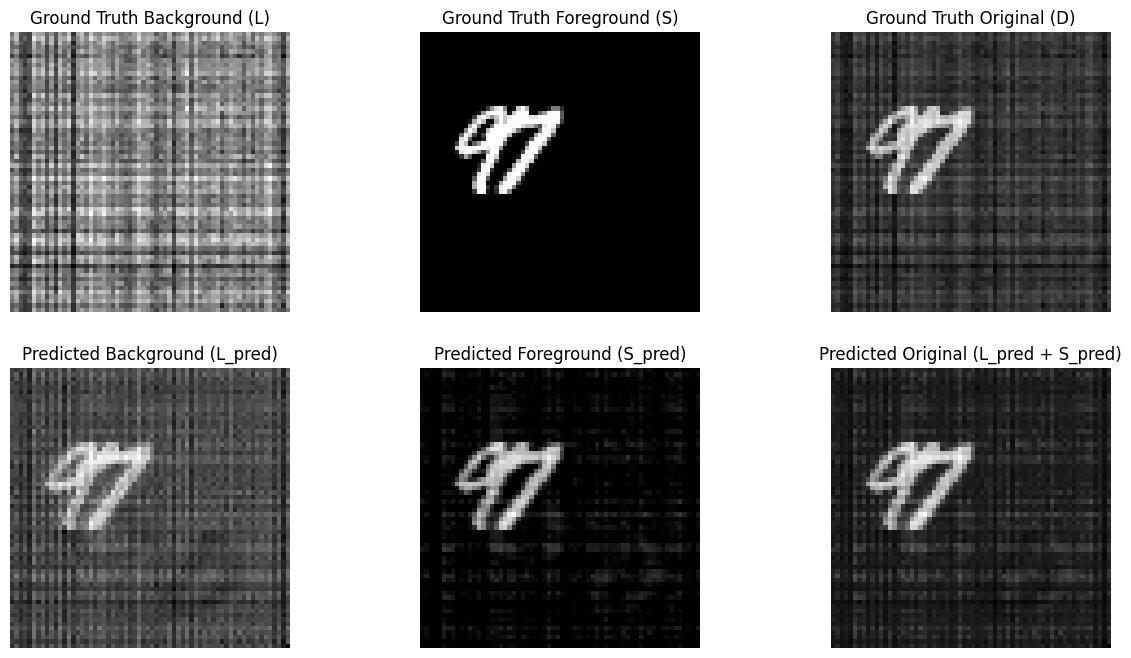

Plot for random frame in batch 4


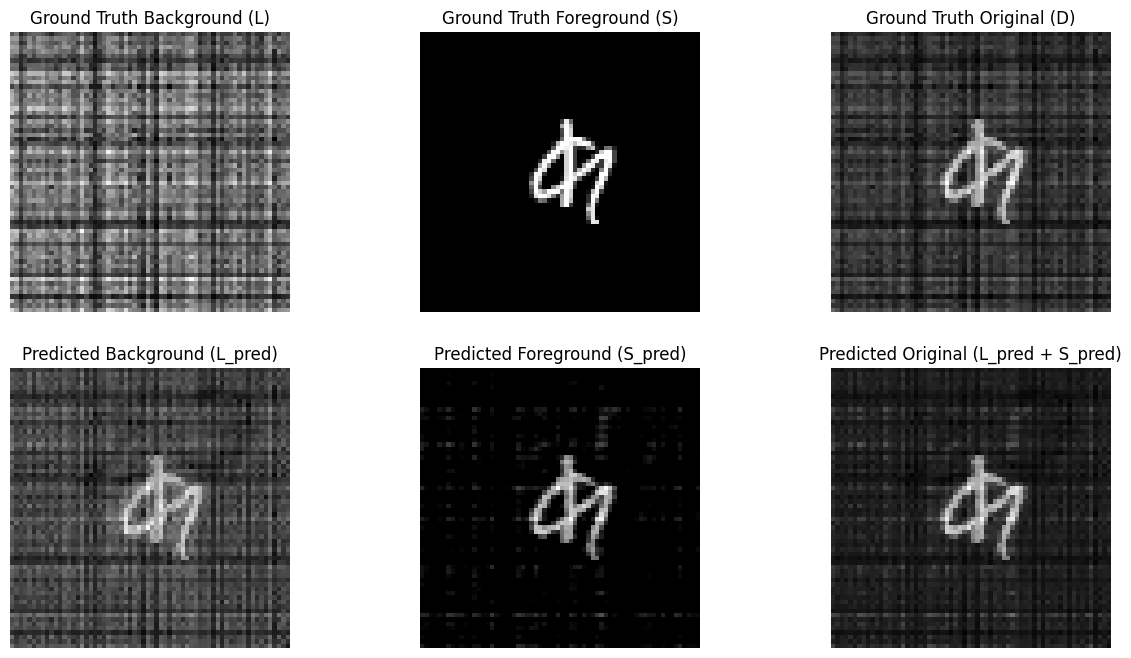

Plot for random frame in batch 5


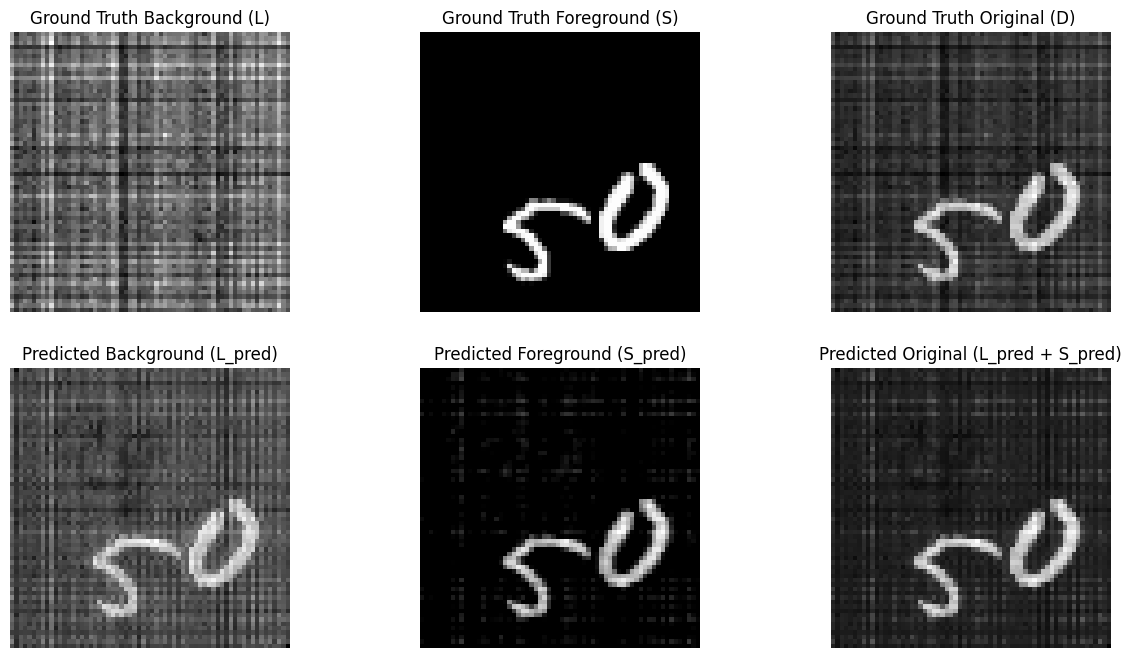

Plot for random frame in batch 6


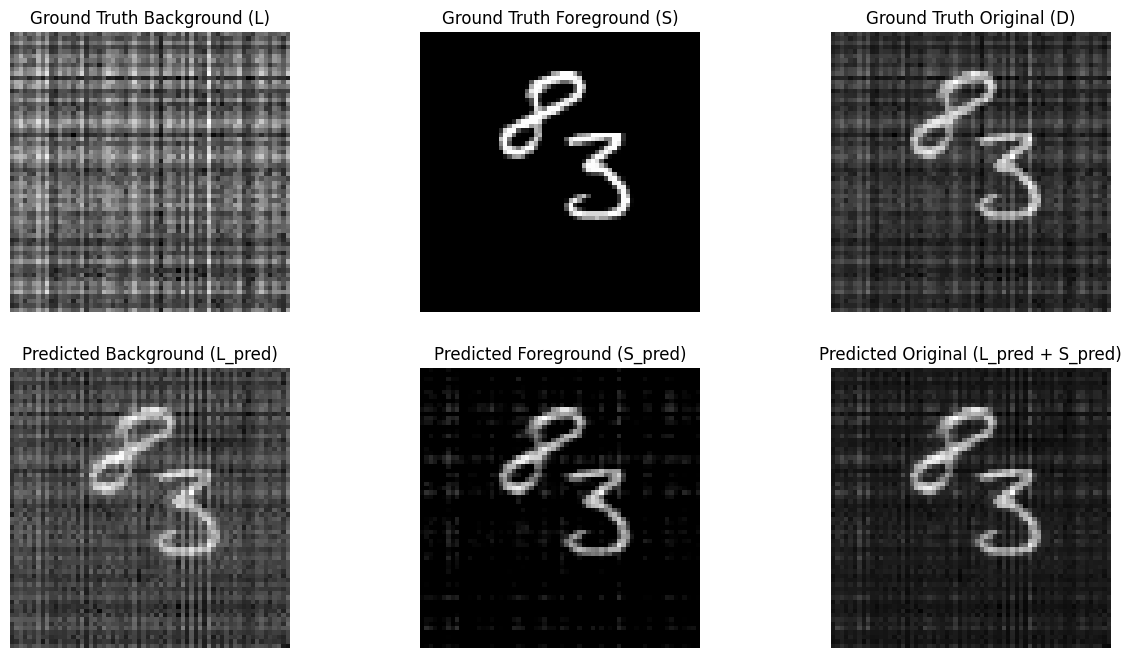

Test Loss: 0.0142
(8, 10)


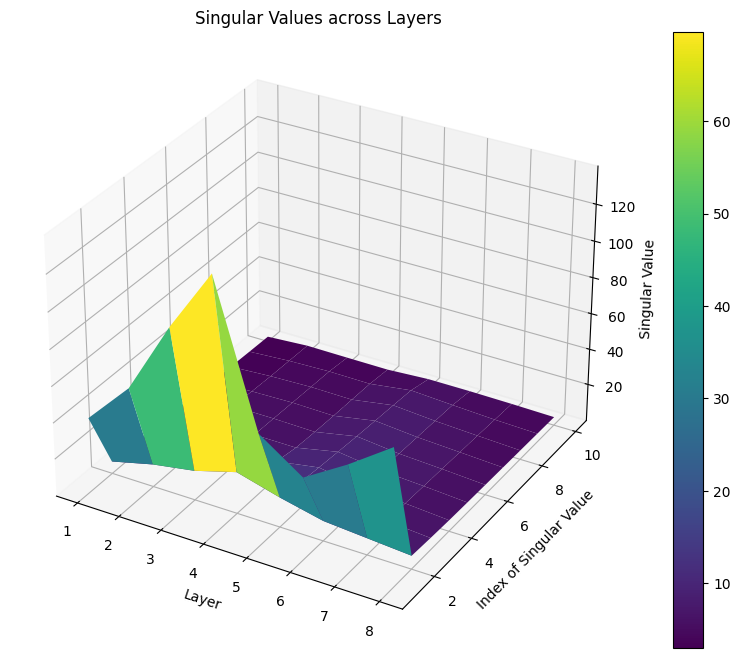

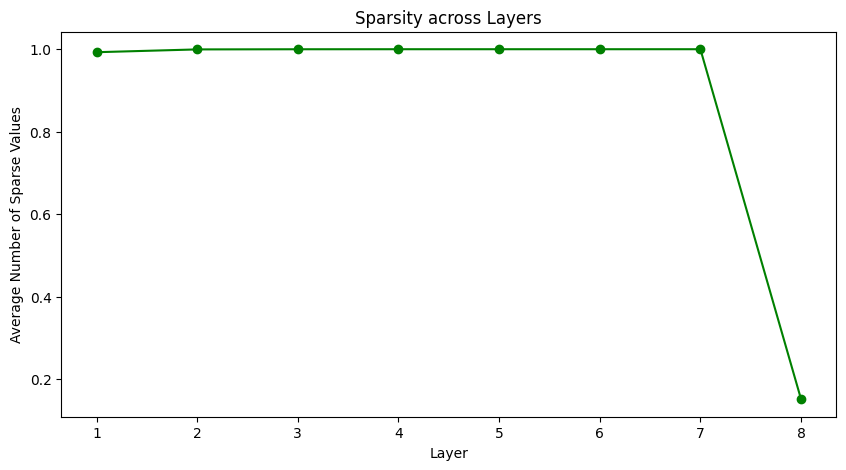

Average Test Loss: 0.0142


In [13]:
# Evaluate the model
# evaluate(model, test_loader, loss_fn, configs)
configs = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 250,  
}

avg_loss = evaluate(model, test_loader, loss_fn, configs)
print(f"Average Test Loss: {avg_loss:.4f}")

# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.